In [1]:
# define waypoints
# waypoint given as [t, y, z]
# the quadrotor need find itself at coordinates (y, z) at time t

wp = [[0, 0, 0], [1, 1, 2], [2, 3, 3], [3, 5, 6], [5, 8, 4], [7, 10, 2], [9, 12, 5]]

# number of piecewise trajectories between the waypoints
n = len(wp) - 1

In [2]:
# initialise a 6n * 6n coefficient matrix and a 6n-dimensional vector
# we are looking for a trajectory with the minimum snap
# the desired trajectory consists of sections that are described by polynomial functions of t
# it can be shown that the order of the polynomial is 5
# so for each piecewise function, there are 6 parameters to be determined
# we are setting up a matrix equation to compute a total number of 6*n parameters
coeffs = []
ysol = []
zsol = []

In [3]:
# conditions that must be satisfied if r(t) match at each waypoint
for i in range(n):
    # initial value for each piecewise polynomial
    result = [0] * 6 * i
    temp = [wp[i][0]**5, wp[i][0]**4, wp[i][0]**3, wp[i][0]**2, wp[i][0], 1]
    result += temp
    result += [0] * 6 * (n-i-1)
    coeffs.append(result)
    ysol.append(wp[i][1])
    zsol.append(wp[i][2])
    
    # final value for each piecewise polynomial
    result = [0] * 6 * i
    temp = [wp[i+1][0]**5, wp[i+1][0]**4, wp[i+1][0]**3, wp[i+1][0]**2, wp[i+1][0], 1]
    result += temp
    result += [0] * 6 * (n-i-1)
    coeffs.append(result)
    ysol.append(wp[i+1][1])
    zsol.append(wp[i+1][2])

In [4]:
# conditions that must be satisfied if initial speed is zero
result = []
temp = [5 * wp[0][0]**4, 4 * wp[0][0]**3, 3 * wp[0][0]**2, 2 * wp[0][0], 1, 0]
result += temp
result += [0] * 6 * (n-1)
coeffs.append(result)
ysol.append(0)
zsol.append(0)

# conditions that must be satisfied if final speed is zero
result = [0] * 6 * (n-1)
temp = [5 * wp[n][0]**4, 4 * wp[n][0]**3, 3 * wp[n][0]**2, 2 * wp[n][0], 1, 0]
result += temp
coeffs.append(result)
ysol.append(0)
zsol.append(0)

# conditions that must be satisfied if initial acceleration is zero
result = []
temp = [20 * wp[0][0]**3, 12 * wp[0][0]**2, 6 * wp[0][0], 2, 0, 0]
result += temp
result += [0] * 6 * (n-1)
coeffs.append(result)
ysol.append(0)
zsol.append(0)

# conditions that must be satisfied if final acceleration is zero
result = [0] * 6 * (n-1)
temp = [20 * wp[n][0]**3, 12 * wp[n][0]**2, 6 * wp[n][0], 2, 0, 0]
result += temp
coeffs.append(result)
ysol.append(0)
zsol.append(0)

In [5]:
# conditions that must be satisfied if velocity is continuous at each waypoint
for i in range(n-1):
    result = [0] * 6 * i
    temp1 = [5 * wp[i+1][0]**4, 4 * wp[i+1][0]**3, 3 * wp[i+1][0]**2, 2 * wp[i+1][0], 1, 0]
    temp2 = [-5 * wp[i+1][0]**4, -4 * wp[i+1][0]**3, -3 * wp[i+1][0]**2, -2 * wp[i+1][0], -1, 0]
    result += temp1 + temp2
    result += [0] * 6 * (n-i-2)
    coeffs.append(result)
    ysol.append(0)
    zsol.append(0)

In [6]:
# conditions that must be satisfied if acceleration is continuous at each waypoint
for i in range(n-1):
    result = [0] * 6 * i
    temp1 = [20 * wp[i+1][0]**3, 12 * wp[i+1][0]**2, 6 * wp[i+1][0], 2, 0, 0]
    temp2 = [-20 * wp[i+1][0]**3, -12 * wp[i+1][0]**2, -6 * wp[i+1][0], -2, 0, 0]
    result += temp1 + temp2
    result += [0] * 6 * (n-i-2)
    coeffs.append(result)
    ysol.append(0)
    zsol.append(0)

In [7]:
# conditions that must be satisfied if third and fourth derivative of r(t) are also continuous
for i in range(n-1):
    result = [0] * 6 * i
    temp1 = [60 * wp[i+1][0]**2, 24 * wp[i+1][0], 6, 0, 0, 0]
    temp2 = [-60 * wp[i+1][0]**2, -24 * wp[i+1][0], -6, 0, 0, 0]
    result += temp1 + temp2
    result += [0] * 6 * (n-i-2)
    coeffs.append(result)
    ysol.append(0)
    zsol.append(0)
    
for i in range(n-1):
    result = [0] * 6 * i
    temp1 = [120 * wp[i+1][0], 24, 0, 0, 0, 0]
    temp2 = [-120 * wp[i+1][0], -24, 0, 0, 0, 0]
    result += temp1 + temp2
    result += [0] * 6 * (n-i-2)
    coeffs.append(result)
    ysol.append(0)
    zsol.append(0)

In [8]:
# we arrange the coefficients of the polynomials into a column vector c
# they must satisfy the matrix equation of the form M c = Y or Z
# by taking the inverse of M, the coefficients can be obtained

import numpy as np

M = np.array(coeffs)
Y = np.array(ysol)
Z = np.array(zsol)

c_y = np.matmul( np.linalg.inv(M), np.transpose(Y))
c_z = np.matmul( np.linalg.inv(M), np.transpose(Z))

In [9]:
# the desired trajectory in terms of piecewise polynomials
# the function traj_des(t) returns the desired coordinate, velocity and acceleration at time t
def traj_des(t):
    for i in range(n):
        if t >= wp[i][0]:
            y = c_y[6*i] * t**5 + c_y[6*i + 1] * t**4 + c_y[6*i + 2] * t**3 + c_y[6*i + 3] * t**2 + c_y[6*i + 4] * t + c_y[6*i + 5]
            y_dot = 5 * c_y[6*i] * t**4 + 4 * c_y[6*i + 1] * t**3 + 3 * c_y[6*i + 2] * t**2 + 2 * c_y[6*i + 3] * t + c_y[6*i + 4]
            y_dot_dot = 20 * c_y[6*i] * t**3 + 12 * c_y[6*i + 1] * t**2 + 6 * c_y[6*i + 2] * t + 2 * c_y[6*i + 3]
            z = c_z[6*i] * t**5 + c_z[6*i + 1] * t**4 + c_z[6*i + 2] * t**3 + c_z[6*i + 3] * t**2 + c_z[6*i + 4] * t + c_z[6*i + 5]
            z_dot = 5 * c_z[6*i] * t**4 + 4 * c_z[6*i + 1] * t**3 + 3 * c_z[6*i + 2] * t**2 + 2 * c_z[6*i + 3] * t + c_z[6*i + 4]
            z_dot_dot = 20 * c_z[6*i] * t**3 + 12 * c_z[6*i + 1] * t**2 + 6 * c_z[6*i + 2] * t + 2 * c_z[6*i + 3]
    return [[y, y_dot, y_dot_dot], [z, z_dot, z_dot_dot]]

In [10]:
# for testing: check if boundary conditions are satisfied
traj_des(5)

[[8.000000000001819, 0.883911566829596, -0.48893272911675467],
 [4.000000000000483, -3.564849480924636, 0.7479904599874629]]

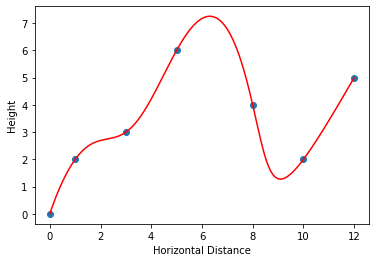

In [11]:
import matplotlib.pyplot as plt
# now we can plot the trajectory and see how it fits all the waypoints

# define constant parameters
t_step = 0.01
n_iter = 900

# setting up the arrays to store desired trajectory
y_des, y_dot_des, y_dotdot_des = [0] * n_iter, [0] * n_iter, [0] * n_iter
z_des, z_dot_des, z_dotdot_des = [0] * n_iter, [0] * n_iter, [0] * n_iter

# compute coordinates of the desired trajectory
for i in range(n_iter):
    t = i * t_step
    y_des[i], y_dot_des[i], y_dotdot_des[i] = traj_des(t)[0]
    z_des[i], z_dot_des[i], z_dotdot_des[i] = traj_des(t)[1]

# extract coordinates of waypoints
Y_wp = []
Z_wp = []
for i in range(len(wp)):
    Y_wp.append(wp[i][1])
    Z_wp.append(wp[i][2])

# plotting the graph of z(t) against y(t)
fig, ax = plt.subplots()
line = ax.plot(y_des, z_des, color='red')
plt.scatter(Y_wp, Z_wp)
plt.xlabel('Horizontal Distance')
plt.ylabel('Height')
plt.show()

In [12]:
# now consider a quadrotor that is required to move through the waypoints
# we have already found an optimal trajectory for the quadrotor
# we can also use PD controller to manipulate its motion so that it travels along the desired path

# define physical constants of the quadrotor
mass = 0.2
Ixx = 0.008
g = 9.81

# define initial state: resting at the origin
y0, y_dot0, y_dotdot0 = 0, 0, 0
z0, z_dot0, z_dotdot0 = 0, 0, 0

# define PD control parameters
Kp_y = 15
Kd_y = 3
Kp_z = 15
Kd_z = 3
Kp_phi = 200
Kd_phi = 20

In [13]:
# setting up the initial values for actual trajectory
y, y_dot, y_dotdot = [0] * n_iter, [0] * n_iter, [0] * n_iter
z, z_dot, z_dotdot = [0] * n_iter, [0] * n_iter, [0] * n_iter
phi, phi_dot, phi_dotdot = [0] * n_iter, [0] * n_iter, [0] * n_iter
phi_des, phi_des_dot = [0] * n_iter, [0] * n_iter
F = [0] * n_iter
tau = [0] * n_iter

t = np.arange(0.0, n_iter*t_step, t_step)

y[0], y_dot[0], y_dotdot[0] = y0, y_dot0, y_dotdot0
z[0], z_dot[0], z_dotdot[0] = z0, z_dot0, z_dotdot0
F[0] = mass * g

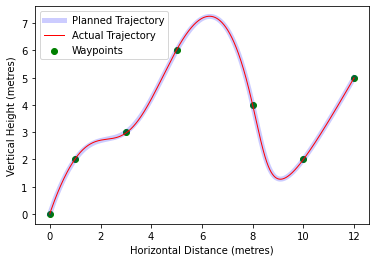

In [14]:
for i in range(1, n_iter):
    # equations of motion for quadrotor in y, z and phi
    y_dotdot[i] = -F[i-1]/mass * np.sin(phi[i-1])
    z_dotdot[i] = F[i-1]/mass * np.cos(phi[i-1]) - g
    phi_dotdot[i] = tau[i-1] / Ixx
    
    # estimate actual trajectory using difference method
    y[i] = y[i-1] + y_dot[i-1] * t_step
    y_dot[i] = y_dot[i-1] + y_dotdot[i-1] * t_step
    z[i] = z[i-1] + z_dot[i-1] * t_step
    z_dot[i] = z_dot[i-1] + z_dotdot[i-1] * t_step
    phi[i] = phi[i-1] + phi_dot[i-1] * t_step
    phi_dot[i] = phi_dot[i-1] + phi_dotdot[i-1] * t_step
    
    # compute the required output from PD controller
    ydotdot_c = y_dotdot_des[i] + Kd_y * (y_dot_des[i] - y_dot[i]) + Kp_y * (y_des[i] - y[i])
    zdotdot_c = z_dotdot_des[i] + Kd_z * (z_dot_des[i] - z_dot[i]) + Kp_z * (z_des[i] - z[i])
    F[i] = mass * np.sqrt(ydotdot_c ** 2 + (g + zdotdot_c) ** 2)
    phi_des[i] = np.arcsin(- mass * ydotdot_c / F[i])
    phi_des_dot[i] = (phi_des[i] - phi_des[i-1])/t_step
    phi_des_dotdot = (phi_des_dot[i] - phi_des_dot[i-1])/t_step
    tau[i] = Ixx * (phi_des_dotdot + Kd_phi * (phi_des_dot[i] - phi_dot[i]) + Kp_phi * (phi_des[i] - phi[i]))

fig, ax = plt.subplots()
plt.scatter(Y_wp, Z_wp, color='green', label='Waypoints')
line1 = ax.plot(y_des, z_des, label='Planned Trajectory', color='blue', linewidth=5, alpha=0.2)
line2 = ax.plot(y, z, label='Actual Trajectory', color='red', linewidth=1)

ax.legend()
plt.ylabel('Vertical Height (metres)')
plt.xlabel('Horizontal Distance (metres)')
plt.show()